# Remove duplicates and split train/test sets

For truevoice-intent dataset
- See the issue at https://github.com/PyThaiNLP/truevoice-intent/issues/2
- Based on https://github.com/PanthonImem/truevoice-intent/blob/master/truevoice-intent_remove-dup_sample-label.ipynb


In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import display

In [4]:
TEST_PORTION = 0.20
RANDOM_SEED = 0

# initializing
random.seed(RANDOM_SEED)
old_train_df = pd.read_csv('mari_train.csv')
old_test_df = pd.read_csv('mari_test.csv')

# concat train and test together  drop duplicates
merged_df = pd.concat([old_train_df, old_test_df]).sort_values('texts')

# drop duplicates on 'texts' and 'destination' column
undup_df = merged_df.drop_duplicates(subset = ['texts','texts_deepcut','action','object','destination'])

print('Got rid of %d duplicated rows' % (old_train_df.shape[0] + old_test_df.shape[0] - undup_df.shape[0]))
print('%d rows remaining', undup_df.shape[0])

Got rid of 2746 duplicated rows
%d rows remaining 13429


In [13]:
#we can separate to object and destination datasets but it's quite a hassle for only 64 rows
print(undup_df.shape[0] - undup_df.texts.nunique())
undup_df[undup_df.texts=='ค่าบริการเอสเอ็มเอส']

64


,texts,texts_deepcut,action,object,destination
712,ค่าบริการเอสเอ็มเอส,ค่า บริการ เอสเอ็มเอส,enquire,promotion,promotions
1752,ค่าบริการเอสเอ็มเอส,ค่า บริการ เอสเอ็มเอส,enquire,rate,promotions


In [14]:
undup_df = undup_df.groupby('texts').max().reset_index()
undup_df

,texts,texts_deepcut,action,object,destination
0,- ครับ ผมขอเช็คหน่อยพอดีเมื่อกี๊ผมไปชำระยอดเง...,- ครับ ผม ขอ เช็ค หน่อย พอดี เมื่อ กี๊ ผม ไป ...,enquire,balance,billing and payment
1,- ค่ะ มียอดค้างชำระเท่าไหร่คะ น้องต่อระบบให้พ...,- ค่ะ มี ยอด ค้าง ชำระ เท่า ไหร่ คะ น้อง ต่อ ...,enquire,balance,billing and payment
2,G ที่เป็นรายเดือนหน่ะค่ะ ตอนนี้มันใช้ครบแล้ว ...,G ที่ เป็น ราย เดือน หน่ะ ค่ะ ตอน นี้ มัน ใช้...,enquire,package,promotions
3,G ที่ใช้กับโปรโมชั่นมันหมด ถ้าจะเติมจะทำยังไง...,G ที่ ใช้ กับ โปรโมชั่น มัน หมด ถ้า จะ เติม จ...,enquire,promotion,promotions
4,G ผมปกติโหลดได้ MB MB แต่วันนี้มันไม่ถึง เลยค...,G ผม ปกติ โหลด ได้ MB MB แต่ วัน นี้ มัน ไม่ ...,enquire,internet,internet
...,...,...,...,...,...
13360,ไอ้ที่ว่าโทรฟรี หมดแล้วรึยังครับ,ไอ้ ที่ ว่า โทรฟรี หมด แล้ว รึยัง ครับ,enquire,package,promotions
13361,ไอ้รายการเมื่อกี้ ใครเป็นพิธีกร,ไอ้ รายการ เมื่อ กี้ ใคร เป็น พิธีกร,garbage,garbage,other queries
13362,ไอ้เบอร์ เบอร์ของคุณแม่คะ หนูยังไม่ได้ไปจ่ายค่...,ไอ้เบอร์ เบอร์ ของ คุณ แม่ คะ หนู ยัง ไม่ ได้ ...,enquire,balance,billing and payment
13363,ไอ้เบอร์เนี่ยที่ว่าจะหมดสัมปทานในเดือนกันยายนเ...,ไอ้เบอร์ เนี่ย ที่ ว่า จะ หมด สัมปทาน ใน เดือน...,change,detail,billing and payment


In [43]:
#deduplication with edit distance with 30-row lookahead window
from fuzzywuzzy import fuzz
import tqdm

idxs = list(undup_df.index)
texts = list(undup_df.texts)
to_skip = []
res = {}
k = 30
fuzz_ratios = []

for i in tqdm.tqdm_notebook(range(undup_df.shape[0])):
    if i in to_skip:
        continue
    if texts[i] not in res.keys():
        res[texts[i]] = []
        for j in range(1,k+1):
            fuzz_ratios.append(fuzz.ratio(texts[i],texts[min(i+j,len(texts)-1)]))
            if fuzz.ratio(texts[i],texts[min(i+j,len(texts)-1)]) > 90:
                res[texts[i]].append(texts[min(i+j,len(texts)-1)])
                to_skip.append(min(i+j,len(texts)-1))

/Users/admin/.virtualenvs/sandbox/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


(array([   576.,  14074.,  90094., 151680.,  83845.,  30420.,  10809.,
          3793.,   1421.,    588.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

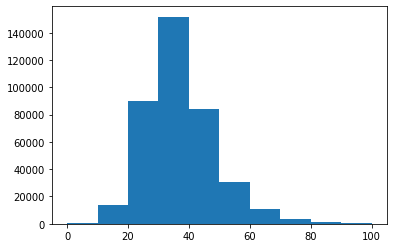

In [44]:
#fuzzy score with 30-row lookahead window
plt.hist(fuzz_ratios)

In [47]:
#about 455 rows can be deduped at 90% similarity threshold
len(res.keys()), undup_df.shape

(12910, (13365, 5))

In [46]:
#things that are too similar with edit distance
for k in list(res.keys()):
    if len(res[k])>1:
        print(f'KEY: {k}\n')
        for t in res[k]:
            print(f'* TEXT: {t}\n')

KEY: ขอเปิดสัญญาณการใช้งาน

* TEXT: ขอเปิดสัญญาณการใช้งานครับ

* TEXT: ขอเปิดสัญญาณใช้งาน

KEY: จะขอเปลี่ยนโปรโมชั่น

* TEXT: จะขอเปลี่ยนโปรโมชั่น ค่ะ

* TEXT: จะขอเปลี่ยนโปรโมชั่นค่ะ

KEY: จะขอเปิดสัญญาณชั่วคราว

* TEXT: จะขอเปิดสัญญาณชั่วคราวครับ

* TEXT: จะขอเปิดสัญญาณชั่วคราวค่ะ

KEY: จะยกเลิกข้อความคะ

* TEXT: จะยกเลิกข้อความค่ะ

* TEXT: จะยกเลิกข้อความนะคะ

* TEXT: จะยกเลิกข้อความอะคะ

* TEXT: จะยกเลิกข้อความอะค่ะ

* TEXT: จะยกเลิกข้อความอ่ะ

KEY: จะสมัคร Package อินเตอร์เน็ตค่ะ

* TEXT: จะสมัครPackage อินเตอร์เน็ต 

* TEXT: จะสมัครPackage อินเตอร์เน็ตค่ะ

KEY: จะสมัคร อินเตอร์ ค่ะ

* TEXT: จะสมัคร อินเตอร์เน๊ต ค่ะ

* TEXT: จะสมัครอินเตอร์ค่ะ

KEY: จะสมัครอินเตอร์เน็ต บ.ค่ะ

* TEXT: จะสมัครอินเตอร์เน็ตค่ะ

* TEXT: จะสมัครอินเตอร์เน๊ต ค่ะ

KEY: จะสมัครเพกเกจอินเตอร์เน็ตค่ะ

* TEXT: จะสมัครเพกเกจอินเตอร์เน็ตต่ออะค่ะ

* TEXT: จะสมัครเพ็กเกจอินเตอร์เน็ตค่ะ

KEY: จะสมัครแพคเกจอินเตอร์เน็ต 

* TEXT: จะสมัครแพคเกจอินเตอร์เน็ตครับ

* TEXT: จะสมัครแพ็กเกจ อินเตอร์เน็ต

* TEXT: จะสมัครแพ็ค

In [49]:
key_df = pd.DataFrame({'texts':list(res.keys())})
undup_df = undup_df.merge(key_df)
undup_df

,texts,texts_deepcut,action,object,destination
0,- ครับ ผมขอเช็คหน่อยพอดีเมื่อกี๊ผมไปชำระยอดเง...,- ครับ ผม ขอ เช็ค หน่อย พอดี เมื่อ กี๊ ผม ไป ...,enquire,balance,billing and payment
1,- ค่ะ มียอดค้างชำระเท่าไหร่คะ น้องต่อระบบให้พ...,- ค่ะ มี ยอด ค้าง ชำระ เท่า ไหร่ คะ น้อง ต่อ ...,enquire,balance,billing and payment
2,G ที่เป็นรายเดือนหน่ะค่ะ ตอนนี้มันใช้ครบแล้ว ...,G ที่ เป็น ราย เดือน หน่ะ ค่ะ ตอน นี้ มัน ใช้...,enquire,package,promotions
3,G ที่ใช้กับโปรโมชั่นมันหมด ถ้าจะเติมจะทำยังไง...,G ที่ ใช้ กับ โปรโมชั่น มัน หมด ถ้า จะ เติม จ...,enquire,promotion,promotions
4,G ผมปกติโหลดได้ MB MB แต่วันนี้มันไม่ถึง เลยค...,G ผม ปกติ โหลด ได้ MB MB แต่ วัน นี้ มัน ไม่ ...,enquire,internet,internet
...,...,...,...,...,...
12905,ไอ้ที่ว่าโทรฟรี หมดแล้วรึยังครับ,ไอ้ ที่ ว่า โทรฟรี หมด แล้ว รึยัง ครับ,enquire,package,promotions
12906,ไอ้รายการเมื่อกี้ ใครเป็นพิธีกร,ไอ้ รายการ เมื่อ กี้ ใคร เป็น พิธีกร,garbage,garbage,other queries
12907,ไอ้เบอร์ เบอร์ของคุณแม่คะ หนูยังไม่ได้ไปจ่ายค่...,ไอ้เบอร์ เบอร์ ของ คุณ แม่ คะ หนู ยัง ไม่ ได้ ...,enquire,balance,billing and payment
12908,ไอ้เบอร์เนี่ยที่ว่าจะหมดสัมปทานในเดือนกันยายนเ...,ไอ้เบอร์ เนี่ย ที่ ว่า จะ หมด สัมปทาน ใน เดือน...,change,detail,billing and payment


In [50]:
# shuffle data
undup_df = shuffle(undup_df, random_state = RANDOM_SEED)

In [51]:
# look at text length, to decide about BUCKET_SIZE
undup_df["len"] = undup_df["texts"].str.len()
undup_df.describe()

/Users/admin/.virtualenvs/sandbox/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,len
count,12910.000000
mean,50.320139
std,30.467669
min,4.000000
25%,31.000000
50%,43.000000
75%,62.000000
max,440.000000


In [52]:
# sample train-test from each label separately to ensure similar distribution in text size between train-test

# put texts in to 9 buckets of these lenghts:
# 0-15, 16-30, 31-45, 46-60, 61-75, 76-90, 91-105, 106-120, 121+
BUCKET_SIZE = 15  # based on dataset characteristics
BUCKET_NUM = 9
def bucket(size):
    size = size - 1
    i = int(size / BUCKET_SIZE)
    if i > BUCKET_NUM - 1:
        i = BUCKET_NUM - 1
    return i

undup_df["size"] = undup_df["len"].apply(bucket)
undup_bysize_ls = [pd.DataFrame(y) for x, y in undup_df.groupby("size", as_index=False)]
del undup_df

/Users/admin/.virtualenvs/sandbox/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
# sample train-test from each label separately to ensure similar distribution in labels between train-test
train_ls, test_ls = [], []

# iterate over DataFrames, grouped by text length
for i in range(0, BUCKET_NUM):
    print("\nLength Bucket: %d" % i)
    print("Samples   Label")
    df = undup_bysize_ls[i]
    for label in df['destination'].unique():
        print('%7d   %s' % ((df[df.destination == label].shape[0]), (label)))
        label_df = df[df.destination == label]
        _train_df, _test_df = train_test_split(label_df, test_size=TEST_PORTION, random_state=RANDOM_SEED)
        train_ls.append(_train_df)
        test_ls.append(_test_df)

# concat the samples together
train_df = pd.concat(train_ls)
test_df = pd.concat(test_ls)
train_df = train_df.drop(columns=["size"])
test_df = test_df.drop(columns=["size"])

# shuffle post-concatenation
train_df = shuffle(train_df, random_state=RANDOM_SEED)
test_df = shuffle(test_df, random_state=RANDOM_SEED)

print()
print('Train Set Size', len(train_df))
print('Test Set Size',len(test_df))

# multi-intent case
# move rows with texts that are both in train and test to train
movels = set(train_df['texts'].values).intersection(set(test_df['texts'].values))
train_df = pd.concat([train_df, test_df[test_df['texts'].isin(movels)]])
test_df = test_df[~test_df['texts'].isin(movels)]

print()
print('post-moving:')
print('Train Set Size', len(train_df))
print('Test Set Size',len(test_df))

display(train_df[:3])


Length Bucket: 0
Samples   Label
    129   billing and payment
     69   other queries
     49   internet
     54   promotions
     11   international dialing
     24   lost and stolen
      6   true money

Length Bucket: 1
Samples   Label
    949   billing and payment
    410   internet
    624   other queries
    656   promotions
    111   international dialing
     73   lost and stolen
     56   true money

Length Bucket: 2
Samples   Label
    660   other queries
   1377   billing and payment
    942   promotions
    552   internet
    151   international dialing
     67   true money
     58   lost and stolen

Length Bucket: 3
Samples   Label
   1015   billing and payment
    412   internet
    533   promotions
    417   other queries
     70   international dialing
     29   lost and stolen
     51   true money

Length Bucket: 4
Samples   Label
    232   internet
    215   other queries
    604   billing and payment
     37   international dialing
     34   true money
    295   pr

,texts,texts_deepcut,action,object,destination,len
8744,สอบถาม package internet ว่ามีแบบไหนบ้างครับ,สอบถาม package internet ว่า มี แบบ ไหน บ้าง ครับ,enquire,promotion,promotions,43
6615,พอดีพี่ซื้อเบอร์ซิม Inter ไปแล้ว แต่ยังไม่ได้ล...,พอดี พี่ ซื้อ เบอร์ซิม Inter ไป แล้ว แต่ ยัง ไ...,enquire,detail,billing and payment,97
1819,ค่ะ พี่ค่ะ คืออยู่ๆ เน็ตเล่นไม่ได้อ่ะค่ะ,ค่ะ พี่ ค่ะ คือ อยู่ ๆ เน็ต เล่น ไม่ ได้ อ่ะ ค่ะ,enquire,internet,internet,40


In [54]:
# check if train-test sets have similar text length distribution
print()
print("Text length distribution in Train Set")
display(train_df.describe())
print("Text length distribution in Test Set")
display(test_df.describe())

train_df = train_df.drop(columns=["len"])
test_df = test_df.drop(columns=["len"])

# count each labels in train and test set
print('Label Count in Train Set')
count_train = train_df.groupby('destination')['texts'].nunique().to_frame('count').reset_index()
display(count_train)

print('Label Count in Test Set')
count_test = test_df.groupby('destination')['texts'].nunique().to_frame('count').reset_index()
display(count_test)

train_df.to_csv('mari-train-undup-balanced-label.csv', index=False)
test_df.to_csv('mari-test-undup-balanced-label.csv', index=False)


Text length distribution in Train Set


,len
count,10303.000000
mean,50.328351
std,30.492591
min,4.000000
25%,31.000000
50%,43.000000
75%,62.000000
max,370.000000


Text length distribution in Test Set


,len
count,2607.000000
mean,50.287687
std,30.374790
min,6.000000
25%,31.000000
50%,43.000000
75%,62.000000
max,440.000000


Label Count in Train Set


,destination,count
0,billing and payment,3916
1,international dialing,336
2,internet,1588
3,lost and stolen,172
4,other queries,1823
5,promotions,2280
6,true money,188


Label Count in Test Set


,destination,count
0,billing and payment,982
1,international dialing,90
2,internet,402
3,lost and stolen,47
4,other queries,459
5,promotions,575
6,true money,52
